In [1]:
from models import EquiNN, PEquiNN, MultiSetModel, SetModel, simple_model, simple_multi_model, entropy_model
import torch
import torch.nn as nn
import math
from torch.distributions import OneHotCategorical, Normal

use_cuda=torch.cuda.is_available()

In [2]:
def generate_categorical(batch_size, classes=5):
    logits = torch.randint(5, size=(batch_size, classes)).float()
    n_samples = torch.randint(100,150,(1,))
    dist = OneHotCategorical(logits=logits)
    samples=dist.sample(n_samples).transpose(0,1)
    return [samples.float()]

def generate_gaussian_1d(batch_size, return_params=False):
    mus, sigmas = (1+5*torch.rand(size=(batch_size, 2))).chunk(2, dim=-1)
    n_samples = torch.randint(100,150,(1,))
    dist = Normal(mus, sigmas)
    samples=dist.sample(n_samples).transpose(0,1)
    if not return_params:
        return [samples.float()]
    else:
        return [samples.float()], (mus, sigmas)

def generate_multi(fct):
    return lambda *args: fct(*args)[0], fct(*args)[0]

def generate_multi_params(fct):
    def generate(*args):
        (X,), T_x = fct(*args, return_params=True)
        (Y,), T_y = fct(*args, return_params=True)
        return (X,Y), (T_x, T_y)
    return generate

def mode(samples):
    return samples.sum(dim=1).argmax(dim=-1)

def entropy(samples):
    counts = samples.sum(dim=-2) + 1
    probs = counts / counts.sum(dim=-1, keepdim=True)
    return -1 * (probs * torch.log(probs)).sum(dim=-1)

def KL_categorical(X, Y):
    counts_X = X.sum(dim=-2) + 1
    counts_Y = Y.sum(dim=-2) + 1
    probs_X = counts_X / counts_X.sum(dim=-1, keepdim=True)
    probs_Y = counts_Y / counts_Y.sum(dim=-1, keepdim=True)
    return (probs_X * (torch.log(probs_X) - torch.log(probs_Y))).sum(dim=-1)

def knn(X, k, Y=None, bs=32):
    if Y is None:
        Y = X
        k += 1
    X = X if type(X) == torch.Tensor else torch.Tensor(X)
    Y = Y if type(Y) == torch.Tensor else torch.Tensor(Y)
    outer_bs = Y.size(0)
    N = Y.size(1)
    n_batches = int(math.ceil(N/bs))
    dists = torch.zeros(outer_bs,N)
    if torch.cuda.is_available():
        X = X.to('cuda')
        Y = Y.to('cuda')
        dists=dists.to('cuda')
    for i in range(n_batches):
        j_min = i*bs
        j_max = min(N, (i+1)*bs)
        all_dists_i = (Y[:,j_min:j_max].unsqueeze(2) - X.unsqueeze(1)).norm(dim=-1)
        topk_i = all_dists_i.topk(k, dim=-1, largest=False)[0][:,:,k-1]
        dists[:,j_min:j_max] = topk_i
    return dists

def kl_knn(X, Y, k=1):
    n = X.size(1)
    m = Y.size(1)
    d = X.size(-1)

    nu = knn(X=Y, Y=X, k=k)
    eps = knn(X=X, k=k)

    return d/n * torch.log(nu/eps).sum(dim=1) + math.log(m/(n-1))

def kl_1d_gaussian(mu1, sigma1, mu2, sigma2):
    return torch.log(sigma2/sigma1) + (sigma1*sigma1 + (mu1-mu2)*(mu1-mu2))/2/sigma2/sigma2 - 1./2

def avg_nn_dist(X):
    dists = knn(X, 1)
    return dists.sum(dim=-1)/dists.size(-1)

def train(model, sample_fct, label_fct, criterion=nn.L1Loss(), batch_size=64, steps=3000, lr=1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for _ in range(steps):
        X = sample_fct(batch_size=batch_size)
        labels = label_fct(*X)
        loss = criterion(model(*X).squeeze(-1), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [3]:
import sys
!{sys.executable} -m pip install seaborn
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (8, 4)}, style="whitegrid")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


No handles with labels found to put in legend.


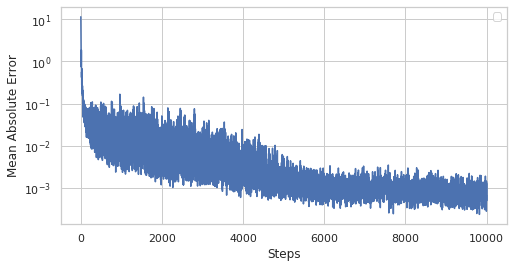

In [4]:
model=simple_model(5,1)
losses=train(model, generate_categorical, entropy, criterion=nn.MSELoss(), steps=10000, lr=1e-3)

plt.plot(losses)
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Mean Absolute Error")
plt.yscale("log")
plt.show()

In [7]:
sample_data=generate_categorical(4)
print(entropy(*sample_data), "\n", model(*sample_data).detach())

tensor([0.9758, 0.8602, 1.4352, 0.9561]) 
 tensor([[0.9826],
        [0.8591],
        [1.4547],
        [0.9600]])


No handles with labels found to put in legend.


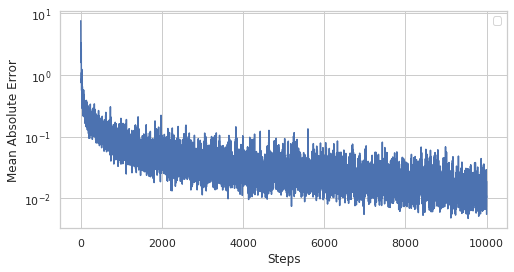

In [8]:
model=simple_multi_model(5,1)
losses=train(model, generate_multi(generate_gaussian_1d), KL_categorical, criterion=nn.MSELoss(), steps=10000, lr=1e-3)

plt.plot(losses)
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Mean Absolute Error")
plt.yscale("log")
plt.show()

In [9]:
sample_data=generate_categorical_multi(4)
print(KL_categorical(*sample_data), "\n", model(*sample_data).detach())

tensor([0.5114, 0.2766, 2.8292, 0.9766]) 
 tensor([[0.5302],
        [0.3623],
        [2.9130],
        [0.9716]])


No handles with labels found to put in legend.


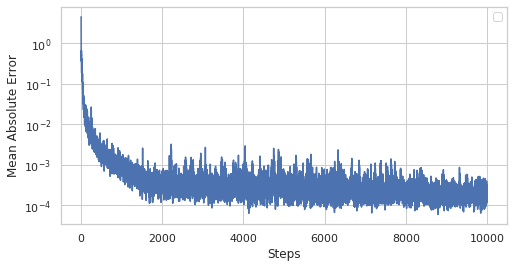

In [4]:
model=entropy_model(1,1)
losses=train(model, generate_gaussian_1d, avg_nn_dist, criterion=nn.MSELoss(), steps=2500, lr=1e-3)

plt.plot(losses)
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Mean Absolute Error")
plt.yscale("log")
plt.show()

In [6]:
sample_data=generate_gaussian_1d(8)
print(avg_nn_dist(*sample_data), "\n", model(*sample_data).detach())

tensor([0.0323, 0.0781, 0.0290, 0.0502, 0.0964, 0.0378, 0.0337, 0.1202]) 
 tensor([[0.0238],
        [0.1027],
        [0.0226],
        [0.0450],
        [0.1050],
        [0.0349],
        [0.0486],
        [0.1115]])
